In [2]:
%matplotlib inline

import os
import sys
import json
import logging
import warnings
warnings.filterwarnings('ignore')

# 更改为自己的路径,或者直接在环境变量中添加
sys.path.append('/Users/zhenwei.jin/Documents/repos/genie')

import pandas as pd
import numpy as np
from jinja2 import Template

#python3种reload函数不能直接使用
from imp import reload

from utils3.data_io_utils import *
import utils3.misc_utils as mu
import utils3.summary_statistics as ss
import utils3.metrics as mt
import utils3.feature_selection as fs
import utils3.plotting as pl
import utils3.modeling as ml
from functools import reduce
import xgboost as xgb
import utils3.verify_performance as vp

# 设置工作路径

In [3]:
DATA_PATH='/Users/zhenwei.jin/Desktop/sample_weight/logistic/02_data'
RESULT_PATH='/Users/zhenwei.jin/Desktop/sample_weight/logistic/03_result/'

# 读取建模字典

In [4]:
var_dict=pd.read_excel(DATA_PATH+'/建模字典.xlsx')

# 读取建模数据

注该样本已完成数据格式和缺失值的填充,若未完成,需要提前做好。

In [5]:
all_x_y=load_data_from_pickle(DATA_PATH,'抽样建模DEMO.pkl')

In [6]:
all_x_y.index=all_x_y.apply_id

## 增加sample_weight

sample_weight的添加方式，建议结合自身的抽样情况决定。

In [7]:
segment_label='channel_class'
sample_weight_model={'Bad Channel':{'good_sample':7.46,'bad_sample':2.43},\
               'Good Channel':{'good_sample':6.42,'bad_sample':1},\
              'Normal Channel':{'good_sample':20.79,'bad_sample':3.19}}

In [8]:
model_data=all_x_y[all_x_y['sample_set']!='OOT']

In [9]:
model_data=mt.BinWoe().add_sample_weight(model_data,segment_label,sample_weight_model)

# 整理X,y,sample_weight数据

In [17]:
X=model_data[var_dict[u'指标英文']]
y=model_data['y']
sample_weight=model_data['sample_weight']

# EDA

## 不包含sample_weight

In [11]:
ss.eda(X, var_dict, useless_vars=[], exempt_vars=[],\
       data_path=RESULT_PATH, save_label='model_data')

## 包含sample_weight

In [19]:
ss.eda_sw(X, var_dict,sample_weight, useless_vars=[], exempt_vars=[],\
       data_path=RESULT_PATH, save_label='model_data_sw')

# 筛掉Summary excluded变量进行综合排序

In [20]:
summary = pd.read_excel(RESULT_PATH+'/model_data_sw_variables_summary.xlsx')
kept = summary.loc[pd.isnull(summary.exclusion_reason), u'指标英文'].tolist()

由于该样本已完成train、test的划分，故此处省略

In [21]:
pd.value_counts(model_data['sample_set'])

MODELING_TRAIN    14000
MODELING_TEST      6000
Name: sample_set, dtype: int64

In [22]:
X_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN',kept]
y_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN','y']
sample_weight_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN','sample_weight']

X_test=model_data.loc[model_data['sample_set']=='MODELING_TEST',kept]
y_test=model_data.loc[model_data['sample_set']=='MODELING_TEST','y']
sample_weight_test=model_data.loc[model_data['sample_set']=='MODELING_TEST','sample_weight']

# 各种算法的overall_ranking

注：目前lasso不支持sample_weight

In [23]:
reload(fs)

<module 'utils3.feature_selection' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/feature_selection.py'>

In [24]:
args_dict = {
    'random_forest': {
        'grid_search': False,#选择了True则会进行网格筛选速度会比较慢
        'param': None
    },
    'xgboost': {
        'grid_search': False,
        'param': None
    }
}
methods = [
    'random_forest', 
    'xgboost'
]

fs_obj = fs.FeatureSelection()

In [25]:
# 使用日志在result_path中可以通过日志观察overall_ranking进行到哪一步了
logging.basicConfig(filename=os.path.join(RESULT_PATH, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)

In [26]:
X_cat_train,X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking_sw(X_train, y_train,sample_weight_train, \
                                                                            var_dict, args_dict, \
                                                                            methods, num_max_bins=5)

[0]	train-auc:0.642005	test-auc:0.631775
[10]	train-auc:0.686562	test-auc:0.665268
[20]	train-auc:0.701183	test-auc:0.674871
[30]	train-auc:0.714785	test-auc:0.680553
[40]	train-auc:0.726777	test-auc:0.686103
[50]	train-auc:0.7353	test-auc:0.690343
[60]	train-auc:0.742019	test-auc:0.693012
[70]	train-auc:0.747779	test-auc:0.694658
[80]	train-auc:0.752129	test-auc:0.695928
[90]	train-auc:0.756814	test-auc:0.696822
[100]	train-auc:0.760749	test-auc:0.697009
[110]	train-auc:0.764285	test-auc:0.697859
[120]	train-auc:0.768262	test-auc:0.698406
[130]	train-auc:0.771692	test-auc:0.698912
[140]	train-auc:0.774749	test-auc:0.698815
[150]	train-auc:0.77803	test-auc:0.699067
[160]	train-auc:0.781188	test-auc:0.698806
[170]	train-auc:0.784066	test-auc:0.698356


建议：将X_cat_train、rebin_spec、woe_iv_df这些数据存储出去，这样就算中途挂掉后续也可以不用重来之前的工作，因为overall_ranking还是很消耗时间的

In [27]:
save_data_to_pickle(X_cat_train,RESULT_PATH,'X_cat_train.pkl')
save_data_to_pickle(woe_iv_df,RESULT_PATH,'woe_iv_df.pkl')
save_data_to_pickle(rebin_spec,RESULT_PATH,'rebin_spec.pkl')
save_data_to_pickle(X_transformed,RESULT_PATH,'X_transformed.pkl')
save_data_to_pickle(ranking_result,RESULT_PATH,'ranking_result.pkl')

# Stepwise步骤

## 留下整体排名靠前的变量

In [28]:
# 确定需要留下的排名靠前变量的数量
n = 250
top_n = ranking_result.sort_values('overall_rank')[u'指标英文'].iloc[:n].tolist()

In [29]:
# 决定从top_n中剔除的字段名称
exclusion = []
# 决定模型一定要有的字段，即使可能不显著
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

In [30]:
# 将数据分箱后并转换woe值
X_transformed_train = X_transformed
# clean data
X_transformed_train = X_transformed_train[selected]

## 相关性筛选

In [31]:
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity(X_transformed_train,RESULT_PATH)

In [32]:
# 这一步时间比较长请大家耐心
vif_result.run(ranking_result)

In [33]:
# 相关性分析删除的变量
exclusion_cols = vif_result.corr_exclude_vars + vif_result.vif_dropvars

## stepwise

In [34]:
new_X_train = X_transformed_train.drop(exclusion_cols, 1)
# 强制必须进入模型的变量
start_from = []

In [35]:
model_result = fs.FeatureSelection().stepwise_sw(new_X_train, y_train,sample_weight_train, LOG, start_from)

In [36]:
model_result = pd.merge(woe_iv_df,model_result, left_on=u'指标英文', right_on='var_code').drop('var_code', 1)
model_result = model_result.sort_values(['AIC_delta', u'指标英文','sort_val'])

# 粗分箱

In [37]:
selected = list(set(model_result[model_result.final_selected==1].指标英文))
selected

['xy_applyLoanQueryNumL3M',
 'tongdun12MIdMultiLoanNumPf',
 'tongdunmicrofinNumPfL6M',
 'tongdunconfinNumPfL6M',
 'nike700Score',
 'tongdunPhoneMultiLoanNum_v2',
 'br_grzz_pc_user_level',
 'ym_credit_score_big',
 'tongdun6MIdXiaofeiFenqiLoanNum',
 'tencentScore_new',
 'tongdunconfinNumPfL3M',
 'br_grzz_pc_rcnt_income',
 'xy_behaviorSuccessPayNumL1M',
 'tongdunotherNumPfL3M',
 'xy_behaviorFailPayNumHist',
 'tongdunP2PNumPfL6M',
 'xy_creditNProductNum',
 'xy_creditFDCreditAmtAvg']

## 图形界面调整分箱

In [38]:
reload(pl)

<module 'utils3.plotting' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/plotting.py'>

In [39]:
ui_obj = pl.BinPlotAdjustUI_sw(X_train, y_train,sample_weight_train,RESULT_PATH,DATA_PATH,rebin_spec, var_dict)
ui_obj.main_ui(selected)

## 储存调整后的结果

In [40]:
rebin_spec_bin_adjusted = {k:v for k,v in ui_obj.rebin_spec.items() if k in selected}
save_data_to_pickle(rebin_spec_bin_adjusted,RESULT_PATH,'rebin_spec_bin_adjusted.pkl')

## 训练集转化WOE

In [41]:
bin_obj = mt.BinWoe()
new_X = X_train[selected]
X_cat_train = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all_sw(X_cat_train, y_train,sample_weight_train,var_dict,rebin_spec_bin_adjusted)
X_transformed_train= bin_obj.transform_x_all(X_cat_train, woe_iv_df_coarse)

In [42]:
woe_iv_df_coarse.to_excel(RESULT_PATH+'/woe_iv_df_coarse.xlsx')

## 测试集转化WOE

In [43]:
new_X = X_test[selected]
X_cat_test = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
X_transformed_test= bin_obj.transform_x_all(X_cat_test, woe_iv_df_coarse)

# 按月查看训练集分箱以后的分布以及逾期率

In [44]:
X_cat_train_with_y_appmon = pd.merge(X_cat_train,model_data[['y','applicationdate']]\
                                     ,left_index=True,right_index=True)

applicationdate改为月份

In [45]:
X_cat_train_with_y_appmon['applicationdate']=X_cat_train_with_y_appmon['applicationdate'].astype(str)

In [46]:
X_cat_train_with_y_appmon['applicationdate']=X_cat_train_with_y_appmon['applicationdate'].apply(lambda x:x[0:7])

In [47]:
reload(ss)

<module 'utils3.summary_statistics' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/summary_statistics.py'>

In [48]:
# 这一步按月统计了变量的分布以及缺失率，这一步可以将字段先存储出去，观察不合格的变量，在下一步可以提前删除
var_dist_badRate_by_time = ss.get_badRate_and_dist_by_time_sw(X_cat_train_with_y_appmon,sample_weight_train,\
                                                              selected,'applicationdate','y',var_dict)

In [49]:
# 建议到这一步的时候讲数据存储出去，观察一下
var_dist_badRate_by_time.to_excel(os.path.join(RESULT_PATH,'var_dist_badRate_by_time.xlsx'))

# 如果此时变量依旧很多建议再来一次stepwise查看调整后变量哪些较为显著

In [50]:
model_result2 = fs.FeatureSelection().stepwise_sw(X_transformed_train, y_train,sample_weight_train,LOG, start_from)

In [51]:
model_result2

,var_code,AIC_delta,step,final_selected
0,xy_applyLoanQueryNumL3M,167.55,FORWARD,1
1,tongdun12MIdMultiLoanNumPf,212.803,FORWARD,1
2,tongdunmicrofinNumPfL6M,9.88513,FORWARD,1
3,tongdunconfinNumPfL6M,NaN,NaN,0
4,nike700Score,2975.39,FORWARD,1
5,tongdunPhoneMultiLoanNum_v2,30.0195,FORWARD,1
6,br_grzz_pc_user_level,85.5443,FORWARD,1
7,ym_credit_score_big,847.43,FORWARD,1
8,tongdun6MIdXiaofeiFenqiLoanNum,136.256,FORWARD,1
9,tencentScore_new,610.335,FORWARD,1


In [52]:
model_result2 = pd.merge(woe_iv_df,model_result2, left_on=u'指标英文', right_on='var_code').drop('var_code', 1)
model_result2 = model_result2.sort_values(['AIC_delta', u'指标英文','sort_val'])

In [53]:
selected = list(set(model_result2[model_result2.final_selected==1].指标英文))
selected

['xy_applyLoanQueryNumL3M',
 'tongdun12MIdMultiLoanNumPf',
 'tongdunmicrofinNumPfL6M',
 'nike700Score',
 'tongdunPhoneMultiLoanNum_v2',
 'ym_credit_score_big',
 'tongdun6MIdXiaofeiFenqiLoanNum',
 'tencentScore_new',
 'tongdunconfinNumPfL3M',
 'xy_creditNProductNum',
 'xy_behaviorSuccessPayNumL1M',
 'br_grzz_pc_rcnt_income',
 'tongdunotherNumPfL3M',
 'xy_behaviorFailPayNumHist',
 'br_grzz_pc_user_level',
 'xy_creditFDCreditAmtAvg']

## 建议拒绝的标签

In [54]:
exclude_var=['tongdun12MIdMultiLoanNumPf','tongdunconfinNumPfL3M','tongdunotherNumPfL3M','tongdunPhoneMultiLoanNum_v2','xy_applyLoanQueryNumL3M','xy_creditNProductNum']

In [55]:
to_keep=list(set(selected).difference(set(exclude_var)))

# 模型评估

In [59]:
reload(ss)

<module 'utils3.summary_statistics' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/summary_statistics.py'>

In [60]:
sample_split_summary = ss.sample_split_summary_sw(y_train,y_test,sample_weight)
sample_split_summary

,split,total,good,bad,rate,dist
0,train,105433.35,89138.89,16294.46,0.1545,0.7
1,test,46050.54,39213.58,6836.96,0.1485,0.3
2,sum,151483.89,128352.47,23131.42,0.1527,1.0


## 拟合模型

In [75]:
reload(ml)

<module 'utils3.modeling' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/modeling.py'>

In [76]:
Logistics_model_obj = ml.LogisticModel(var_dict,y_train,y_test)

In [63]:
Logistics_model_result = Logistics_model_obj.fit_model_sw('test_model',X_transformed_train,X_transformed_test,sample_weight_train,sample_weight_test,in_model=to_keep)

good_sw


### 训练集拟合结果

In [64]:
Logistics_model_result['train_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-1.702,0.009,35693.873,0.000,-1.720,-1.684
nike700Score,高德反欺诈定制分,0.593,0.023,658.391,0.000,0.547,0.638
tongdunmicrofinNumPfL6M,近6个月内同盾对于小额贷款公司借款平台数,0.458,0.127,12.949,0.000,0.209,0.708
ym_credit_score_big,友盟大额通用分,0.524,0.024,479.923,0.000,0.477,0.571
tongdun6MIdXiaofeiFenqiLoanNum,6个月内身份证一般消费分期平台借款申请次数,0.476,0.050,91.376,0.000,0.378,0.574
tencentScore_new,腾讯新版通用分,0.918,0.037,608.325,0.000,0.845,0.991
br_grzz_pc_rcnt_income,近期收入能力,0.627,0.037,282.951,0.000,0.554,0.700
xy_behaviorSuccessPayNumL1M,近1个月贷款机构成功扣款笔 数,0.161,0.089,3.260,0.071,-0.014,0.336
xy_behaviorFailPayNumHist,历史贷款机构失败扣款笔数,1.174,0.039,927.519,0.000,1.099,1.250
br_grzz_pc_user_level,消费信用等级,0.330,0.032,103.406,0.000,0.267,0.394


### 测试集拟合结果

In [65]:
Logistics_model_result['test_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-1.760,0.014,15627.631,0.000,-1.788,-1.733
nike700Score,高德反欺诈定制分,0.655,0.036,322.594,0.000,0.584,0.727
tongdunmicrofinNumPfL6M,近6个月内同盾对于小额贷款公司借款平台数,0.143,0.157,0.831,0.362,-0.164,0.450
ym_credit_score_big,友盟大额通用分,0.603,0.038,255.736,0.000,0.529,0.677
tongdun6MIdXiaofeiFenqiLoanNum,6个月内身份证一般消费分期平台借款申请次数,0.364,0.078,21.741,0.000,0.211,0.518
tencentScore_new,腾讯新版通用分,0.811,0.058,198.508,0.000,0.698,0.924
br_grzz_pc_rcnt_income,近期收入能力,0.795,0.059,184.419,0.000,0.680,0.909
xy_behaviorSuccessPayNumL1M,近1个月贷款机构成功扣款笔 数,0.098,0.138,0.498,0.480,-0.174,0.369
xy_behaviorFailPayNumHist,历史贷款机构失败扣款笔数,1.271,0.061,427.389,0.000,1.150,1.391
br_grzz_pc_user_level,消费信用等级,0.372,0.049,58.661,0.000,0.276,0.467


对比分析建议删除tongdunmicrofinNumPfL6M和xy_behaviorSuccessPayNumL1M这两个字段

In [66]:
exclude_var2=['tongdunmicrofinNumPfL6M','xy_behaviorSuccessPayNumL1M']

In [67]:
to_keep_1=list(set(to_keep).difference(set(exclude_var2)))

In [68]:
Logistics_model_result = Logistics_model_obj.fit_model_sw('test_model',X_transformed_train,X_transformed_test,sample_weight_train,sample_weight_test,in_model=to_keep_1)

good_sw


In [69]:
Logistics_model_result['train_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-1.702,0.009,35701.303,0.000,-1.719,-1.684
nike700Score,高德反欺诈定制分,0.592,0.023,658.115,0.000,0.547,0.638
ym_credit_score_big,友盟大额通用分,0.530,0.024,494.766,0.000,0.483,0.577
tongdun6MIdXiaofeiFenqiLoanNum,6个月内身份证一般消费分期平台借款申请次数,0.484,0.048,101.757,0.000,0.390,0.578
tencentScore_new,腾讯新版通用分,0.919,0.037,610.247,0.000,0.847,0.992
br_grzz_pc_rcnt_income,近期收入能力,0.631,0.037,286.570,0.000,0.558,0.704
xy_behaviorFailPayNumHist,历史贷款机构失败扣款笔数,1.185,0.038,985.802,0.000,1.111,1.259
br_grzz_pc_user_level,消费信用等级,0.328,0.032,102.362,0.000,0.265,0.392
xy_creditFDCreditAmtAvg,消费金融类机构平均授信额度,0.520,0.055,88.051,0.000,0.411,0.629


In [70]:
Logistics_model_result['test_coef']

,指标中文,coef,std err,Chi-Square,Pr>ChiSq,[0.025,0.975]
const,截距,-1.760,0.014,15635.897,0.000,-1.787,-1.732
nike700Score,高德反欺诈定制分,0.654,0.036,322.488,0.000,0.583,0.725
ym_credit_score_big,友盟大额通用分,0.608,0.037,264.053,0.000,0.535,0.682
tongdun6MIdXiaofeiFenqiLoanNum,6个月内身份证一般消费分期平台借款申请次数,0.369,0.076,23.858,0.000,0.221,0.517
tencentScore_new,腾讯新版通用分,0.812,0.058,198.992,0.000,0.699,0.925
br_grzz_pc_rcnt_income,近期收入能力,0.796,0.059,185.148,0.000,0.681,0.911
xy_behaviorFailPayNumHist,历史贷款机构失败扣款笔数,1.277,0.060,452.436,0.000,1.160,1.395
br_grzz_pc_user_level,消费信用等级,0.370,0.048,58.268,0.000,0.275,0.465
xy_creditFDCreditAmtAvg,消费金融类机构平均授信额度,0.910,0.090,103.097,0.000,0.734,1.085


## KS&AUC曲线图

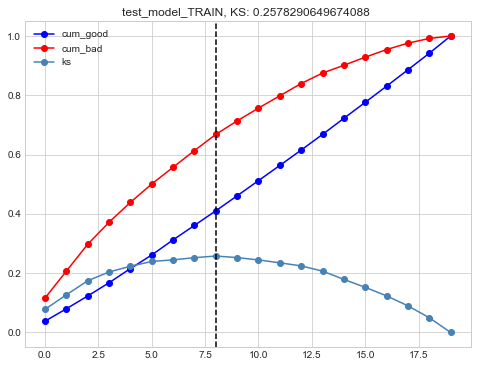

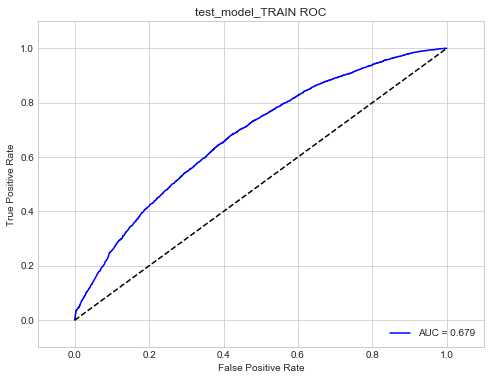

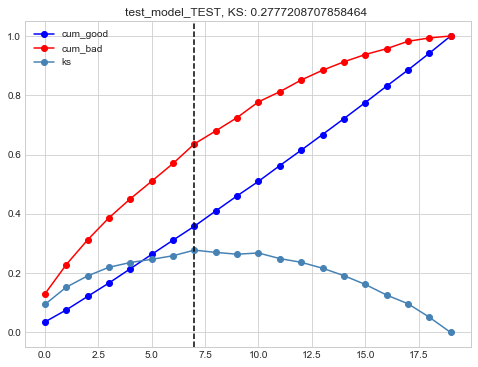

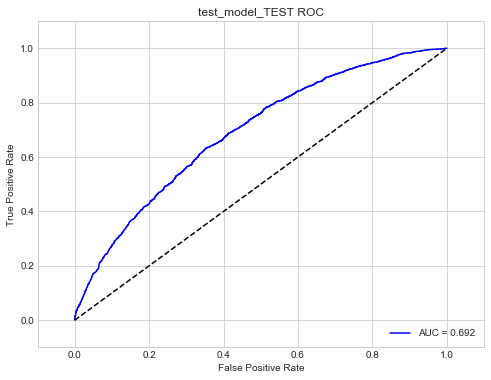

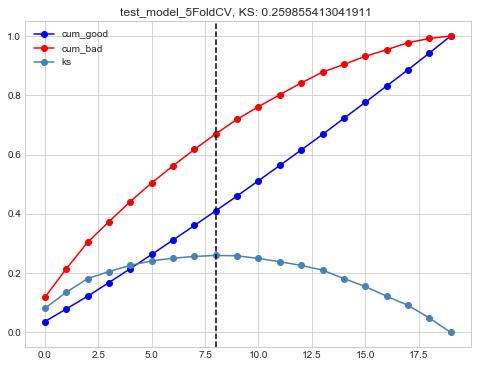

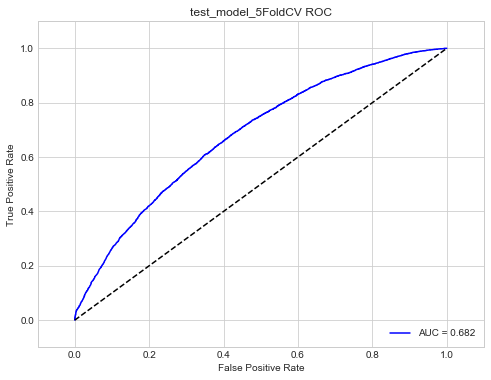

In [77]:
Logistics_model_obj.plot_for_the_model_sw(sample_weight,y,RESULT_PATH,Logistics_model_result, with_test=True)

## 变量相关性系数

In [78]:
corr = X_transformed_train[to_keep_1].corr()
corr

,nike700Score,ym_credit_score_big,tongdun6MIdXiaofeiFenqiLoanNum,tencentScore_new,br_grzz_pc_rcnt_income,xy_behaviorFailPayNumHist,br_grzz_pc_user_level,xy_creditFDCreditAmtAvg
nike700Score,1.000000,0.415729,0.260346,0.040638,0.163816,0.004736,0.464679,0.150154
ym_credit_score_big,0.415729,1.000000,0.192314,0.034820,0.149493,0.034390,0.305605,0.143980
tongdun6MIdXiaofeiFenqiLoanNum,0.260346,0.192314,1.000000,-0.057818,0.028649,-0.092359,0.212428,0.118152
tencentScore_new,0.040638,0.034820,-0.057818,1.000000,0.059684,0.021468,-0.010270,0.030127
br_grzz_pc_rcnt_income,0.163816,0.149493,0.028649,0.059684,1.000000,-0.015598,0.082402,0.102115
xy_behaviorFailPayNumHist,0.004736,0.034390,-0.092359,0.021468,-0.015598,1.000000,-0.004208,-0.067786
br_grzz_pc_user_level,0.464679,0.305605,0.212428,-0.010270,0.082402,-0.004208,1.000000,0.093161
xy_creditFDCreditAmtAvg,0.150154,0.143980,0.118152,0.030127,0.102115,-0.067786,0.093161,1.000000


## 评分卡

In [79]:
coefficients = Logistics_model_result['model_final'].params\
.to_frame('beta').reset_index().rename(columns={'index':'var_code'})

In [80]:
cleaned_woe = woe_iv_df_coarse.loc[woe_iv_df_coarse[u'指标英文'].isin(coefficients.var_code), [u'指标英文', u'分箱', 'N', u'分布占比', 'WOE', u'逾期率', u'Bad分布占比']]
cleaned_woe.head()

,指标英文,分箱,N,分布占比,WOE,逾期率,Bad分布占比
4,tongdun6MIdXiaofeiFenqiLoanNum,"(-inf, -8887.0]",13.84,0.000131,0.000000,0.072254,0.0001
5,tongdun6MIdXiaofeiFenqiLoanNum,"(-8887.0, 0.0]",17921.12,0.169976,0.179287,0.179459,0.1974
6,tongdun6MIdXiaofeiFenqiLoanNum,"(0.0, 5.0]",47933.09,0.454629,0.099285,0.167964,0.4941
7,tongdun6MIdXiaofeiFenqiLoanNum,"(5.0, 10.0]",19854.40,0.188312,-0.067979,0.145864,0.1777
8,tongdun6MIdXiaofeiFenqiLoanNum,"(10.0, 20.0]",13139.72,0.124626,-0.345246,0.114620,0.0924


In [81]:
score_card = mt.Performance().calculate_score(coefficients, cleaned_woe, 'var_score', var_dict)

In [82]:
score_card.to_excel(os.path.join(RESULT_PATH,'score_card.xlsx'))

## 查看decile

In [83]:
selected = [i for i in coefficients.var_code if i != 'const']
train_score = mt.Performance().calculate_score_by_scrd(X_cat_train[selected], score_card)
test_score = mt.Performance().calculate_score_by_scrd(X_cat_test[selected], score_card)

In [84]:
reload(vp)

<module 'utils3.verify_performance' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/verify_performance.py'>

In [85]:
# 训练集
ks_decile_train = vp.get_decile_sw(train_score[1],sample_weight,y, 'decile',manual_cut_bounds=[])[1]
ks_decile_train

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 476.0]",10053.26,6788.57,3264.69,0.324739,0.200356,0.076157,0.200356,0.076157,1.241986e-01,2.079392
1,"(476.0, 501.0]",10686.55,7950.72,2735.83,0.256007,0.167899,0.089195,0.368255,0.165352,2.029033e-01,2.906145
2,"(501.0, 521.0]",10427.22,8343.89,2083.33,0.199797,0.127855,0.093605,0.496110,0.258957,2.371529e-01,4.005074
3,"(521.0, 540.0]",10893.11,9006.83,1886.28,0.173163,0.115762,0.101043,0.611872,0.360000,2.518723e-01,4.774917
4,"(540.0, 560.0]",10361.69,8757.10,1604.59,0.154858,0.098475,0.098241,0.710347,0.458241,2.521058e-01,5.457531
5,"(560.0, 583.0]",10750.44,9317.31,1433.13,0.133309,0.087952,0.104526,0.798299,0.562767,2.355320e-01,6.501371
6,"(583.0, 607.0]",10267.53,9063.12,1204.41,0.117303,0.073915,0.101674,0.872214,0.664441,2.077732e-01,7.524946
7,"(607.0, 634.0]",10671.39,9764.77,906.62,0.084958,0.055640,0.109546,0.927854,0.773987,1.538674e-01,10.770521
8,"(634.0, 670.0]",10703.89,9925.77,778.12,0.072695,0.047754,0.111352,0.975608,0.885338,9.026929e-02,12.756092
9,"(670.0, inf]",10618.27,10220.81,397.46,0.037432,0.024392,0.114662,1.000000,1.000000,2.220446e-16,25.715317


In [86]:
# 测试集
point_bounds = vp.get_decile_sw(train_score[1],sample_weight,y, 'decile',manual_cut_bounds=[])[0]
ks_decile_test=vp.get_decile_sw(test_score[1],sample_weight,y, 'decile',manual_cut_bounds=point_bounds)[1]
ks_decile_test

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 476.0]",4140.68,2698.59,1442.09,0.348274,0.210926,0.068818,0.210926,0.068818,1.421079e-01,1.871305
1,"(476.0, 501.0]",4672.94,3560.21,1112.73,0.238122,0.162752,0.090790,0.373678,0.159608,2.140698e-01,3.199527
2,"(501.0, 521.0]",5143.25,4175.83,967.42,0.188095,0.141499,0.106489,0.515176,0.266097,2.490790e-01,4.316460
3,"(521.0, 540.0]",3948.67,3195.95,752.72,0.190626,0.110096,0.081501,0.625272,0.347598,2.776736e-01,4.245868
4,"(540.0, 560.0]",4902.52,4256.23,646.29,0.131828,0.094529,0.108540,0.719801,0.456138,2.636628e-01,6.585635
5,"(560.0, 583.0]",4770.21,4130.32,639.89,0.134143,0.093593,0.105329,0.813394,0.561467,2.519267e-01,6.454734
6,"(583.0, 607.0]",4808.79,4302.20,506.59,0.105347,0.074096,0.109712,0.887489,0.671179,2.163105e-01,8.492469
7,"(607.0, 634.0]",4269.59,3928.84,340.75,0.079809,0.049839,0.100191,0.937329,0.771370,1.659591e-01,11.529978
8,"(634.0, 670.0]",4426.35,4149.51,276.84,0.062544,0.040492,0.105818,0.977821,0.877188,1.006326e-01,14.988838
9,"(670.0, inf]",4967.54,4815.90,151.64,0.030526,0.022179,0.122812,1.000000,1.000000,-1.110223e-16,31.758771


In [87]:
run_book=vp.get_decile_sw(pd.concat([test_score[1],train_score[1]],join='outer'),sample_weight,y, 'runbook',manual_cut_bounds=[])[1]
run_book

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 458.0]",7566.46,4814.45,2752.01,0.363712,0.118973,0.037510,0.118973,0.037510,8.146321e-02,1.749430
1,"(458.0, 477.0]",7278.78,5158.95,2119.83,0.291234,0.091643,0.040194,0.210616,0.077703,1.329125e-01,2.433662
2,"(477.0, 491.0]",7598.52,5565.45,2033.07,0.267561,0.087892,0.043361,0.298508,0.121064,1.774439e-01,2.737461
3,"(491.0, 502.0]",7838.35,6000.51,1837.84,0.234468,0.079452,0.046750,0.377960,0.167814,2.101458e-01,3.264980
4,"(502.0, 511.0]",6697.92,5393.94,1303.98,0.194684,0.056373,0.042024,0.434333,0.209839,2.244940e-01,4.136520
5,"(511.0, 521.0]",8143.87,6584.51,1559.36,0.191477,0.067413,0.051300,0.501746,0.261139,2.406069e-01,4.222572
6,"(521.0, 530.0]",6914.40,5675.32,1239.08,0.179203,0.053567,0.044217,0.555313,0.305355,2.499572e-01,4.580269
7,"(530.0, 540.0]",7927.38,6527.46,1399.92,0.176593,0.060520,0.050856,0.615833,0.356211,2.596217e-01,4.662738
8,"(540.0, 550.0]",7491.19,6318.34,1172.85,0.156564,0.050704,0.049226,0.666537,0.405438,2.610990e-01,5.387168
9,"(550.0, 560.0]",7773.02,6694.99,1078.03,0.138689,0.046605,0.052161,0.713141,0.457599,2.555426e-01,6.210393


# OOT数据验证

In [88]:
OOT_data=all_x_y[all_x_y['sample_set']=='OOT']

## OOT数据增加sample_weight

In [89]:
sample_weight_oot={'Bad Channel':{'good_sample':8.64,'bad_sample':1},\
               'Good Channel':{'good_sample':14.27,'bad_sample':1},\
              'Normal Channel':{'good_sample':17.88,'bad_sample':1.2}}

In [90]:
OOT_data=mt.BinWoe().add_sample_weight(OOT_data,segment_label,sample_weight_oot)

In [91]:
OOT_data.index=OOT_data['apply_id']

In [92]:
oot_y=OOT_data['y']
sample_weight_oot=OOT_data['sample_weight']

In [93]:
bin_obj = mt.BinWoe()
# 给数据分箱并转化woe
data_OOT_cat = bin_obj.convert_to_category(OOT_data[selected], var_dict, rebin_spec_bin_adjusted)
data_OOT_transformed = bin_obj.transform_x_all(data_OOT_cat, woe_iv_df_coarse)
# 找出模型变量并打分
selected = [i for i in coefficients.var_code if i != 'const']
data_OOT_BScore = mt.Performance().calculate_score_by_scrd(data_OOT_cat[selected], score_card)

In [94]:
# 每一个变量的打分情况
data_OOT_BScore_vars = data_OOT_BScore[0]
# 每个user的打分情况
data_OOT_BScore_detail = data_OOT_BScore[1]

In [95]:
data_OOT_BScore_vars_final = pd.merge(data_OOT_BScore_vars,OOT_data[['y']],left_index=True,right_index=True)
data_OOT_BScore_detail_final = pd.merge(data_OOT_BScore_detail.to_frame('score'),OOT_data[['y']],left_index=True,right_index=True)

In [96]:
reload(vp)

<module 'utils3.verify_performance' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/verify_performance.py'>

In [97]:
OOT_decile = vp.get_decile_sw(data_OOT_BScore_detail,sample_weight_oot,oot_y,'decile',manual_cut_bounds=point_bounds)[1]
OOT_decile

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 476.0]",670.05,581.45,88.6,0.132229,0.083161,0.034045,0.083161,0.034045,4.911592e-02,6.562641
1,"(476.0, 501.0]",1291.46,1181.86,109.6,0.084865,0.102872,0.069201,0.186033,0.103246,8.278727e-02,10.783394
2,"(501.0, 521.0]",1141.63,1020.03,121.6,0.106514,0.114136,0.059725,0.300169,0.162971,1.371975e-01,8.388405
3,"(521.0, 540.0]",1724.98,1605.78,119.2,0.069102,0.111883,0.094022,0.412052,0.256994,1.550580e-01,13.471309
4,"(540.0, 560.0]",1851.39,1734.39,117.0,0.063196,0.109818,0.101553,0.521870,0.358547,1.633231e-01,14.823846
5,"(560.0, 583.0]",1911.59,1782.39,129.2,0.067588,0.121269,0.104363,0.643139,0.462910,1.802288e-01,13.795588
6,"(583.0, 607.0]",2213.17,2098.77,114.4,0.051691,0.107378,0.122888,0.750516,0.585798,1.647181e-01,18.345892
7,"(607.0, 634.0]",2002.93,1899.13,103.8,0.051824,0.097428,0.111199,0.847944,0.696997,1.509476e-01,18.296050
8,"(634.0, 670.0]",2508.73,2430.33,78.4,0.031251,0.073587,0.142302,0.921532,0.839299,8.223316e-02,30.999107
9,"(670.0, inf]",2828.17,2744.57,83.6,0.029560,0.078468,0.160701,1.000000,1.000000,-1.110223e-16,32.829785


In [98]:
OOT_runbook = vp.get_decile_sw(data_OOT_BScore_detail,sample_weight_oot,oot_y,'runbook',manual_cut_bounds=[])[1]
OOT_runbook

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 481.0]",899.04,795.84,103.2,0.114789,0.096865,0.046598,0.096865,0.046598,5.026663e-02,7.711628
1,"(481.0, 498.0]",837.29,757.29,80.0,0.095546,0.075089,0.044341,0.171954,0.090940,8.101460e-02,9.466125
2,"(498.0, 516.0]",957.75,862.55,95.2,0.099400,0.089356,0.050504,0.261310,0.141444,1.198663e-01,9.060399
3,"(516.0, 527.0]",847.33,772.93,74.4,0.087805,0.069833,0.045257,0.331143,0.186701,1.444423e-01,10.388844
4,"(527.0, 537.0]",935.23,875.83,59.4,0.063514,0.055754,0.051282,0.386897,0.237983,1.489140e-01,14.744613
5,"(537.0, 546.0]",931.79,866.59,65.2,0.069973,0.061198,0.050741,0.448095,0.288724,1.593706e-01,13.291258
6,"(546.0, 557.0]",918.34,857.74,60.6,0.065989,0.056880,0.050223,0.504975,0.338947,1.660279e-01,14.154125
7,"(557.0, 566.0]",925.81,874.41,51.4,0.055519,0.048245,0.051199,0.553219,0.390146,1.630738e-01,17.011868
8,"(566.0, 577.0]",809.01,739.41,69.6,0.086031,0.065328,0.043294,0.618547,0.433440,1.851071e-01,10.623707
9,"(577.0, 587.0]",927.25,883.65,43.6,0.047021,0.040924,0.051740,0.659471,0.485180,1.742908e-01,20.267202


# OOT PSI以及ranking验证

## OOT样本每个变量的ranking

In [100]:
# 如果plot设置为TRUE则会在Result_path中画图
var_ranking_train_vs_oot=var_ranking_train_vs_oot = pl.variable_badrate_compare_sw(X_cat_train[selected],y_train,sample_weight_train,data_OOT_cat[selected],oot_y\
                                                    ,sample_weight_oot,'train_set','OOT_set',var_dict,rebin_spec_bin_adjusted,RESULT_PATH\
                                                       ,plot=False)

## 将Train和OOT的decile按照上方的样式合并

In [101]:
ks_decile_train_part = ks_decile_train[['分箱','样本数','逾期率']]
ks_decile_train_part['分布占比'] = ks_decile_train['样本数']/ks_decile_train['样本数'].sum()

In [102]:
OOT_decile['分布占比'] = OOT_decile['样本数']/OOT_decile['样本数'].sum()

In [103]:
score_ranking_train_vs_oot = pd.concat([ks_decile_train_part[['分箱','样本数','逾期率','分布占比']]\
          ,OOT_decile[['样本数','逾期率','分布占比']]],axis=1)

In [104]:
score_ranking_train_vs_oot.columns = \
['分箱', 'train_set样本量', 'train_set逾期率', 'train_set分布占比'\
 , 'OOT_set样本量', 'OOT_set逾期率', 'OOT_set分布占比']
score_ranking_train_vs_oot['数据源'] = '模型分'
score_ranking_train_vs_oot['指标英文'] = 'modelScore'
score_ranking_train_vs_oot['指标中文'] = '模型分'
score_ranking_train_vs_oot['指标类型'] = '/'
score_ranking_train_vs_oot['分箱对应原始分类'] = None

## 将变量ranking与打分ranking合并

In [105]:
# 打分的数据字段排列有点乱，还是沿用变量的字段排序比较好
ranking_train_vs_oot = pd.concat([score_ranking_train_vs_oot,var_ranking_train_vs_oot])\
[var_ranking_train_vs_oot.columns]

## 计算变量和score的PSI

In [106]:
from math import log

In [107]:
ranking_train_vs_oot['PSI'] = ranking_train_vs_oot.apply(lambda x : (x['OOT_set分布占比'] - x['train_set分布占比'])\
                           *log(x['OOT_set分布占比']/x['train_set分布占比'])\
                           if x['OOT_set分布占比']!=0 and x['train_set分布占比']!=0 else 0\
                           ,axis=1)

# 模型部署

In [108]:
import utils3.deploy as dp 

In [109]:
'''
model_label (str): 模型名称
live_abbr (str): 上线后模型输出打分字段尾缀名称
RESULT_PATH (str): 结果路径
score_card (dataFrame): 建模评分卡
model_decile(dataFrame): 建模decile
eda_table (dataFrame): EDA结果
coarse_classing_rebin_spec (dict): 建模分箱边界文件
production_modelName (str): 需要部署的模型在线上部署时所在的条用modelName，取值问部署人员
product_name (str): 中间层表格中的product_name取值。传入这个模型所部署的产品名
liftcurve_name_map (dict): 画lift curve的时候原始model_label转换成图中的
    显示名称，因为画图会将中文显示成方格，所以转换的值需全为英文。取名时请注意规范一致
    性和可读性和理解性，因为这个是会放到最终报告中的。如果有用于对比表现的老模型，也
    需要包含。key值为建模时各模型对应的model_label, value值为规范刻度和解释性较好
    的全英文正式模型名称
production_name_map (dict): 当有指标英文线上的名字和线下建模时不一样时传入。key=建模时英文名
    value=线上英文名。 default={} 默认建模时和线上没有命名不一致的情况
'''
dp.generate_logistics_scorecard_deployment_documents('PCS_OnlineCashScoreB', 'pcsonlineplb',
                                            RESULT_PATH,score_card,ks_decile_train,
                                            summary,
                                            rebin_spec_bin_adjusted,
                                            'PCS_OnlineCashScoreB', 'PCS_OnlineCashScoreB',
                                            production_name_map={})

# 模型文档整理

In [110]:
FINAL_REPORT_PATH = '/Users/zhenwei.jin/Desktop/sample_weight/logistic/03_result/result'

In [111]:
import utils3.filing as fl
reload(fl)

<module 'utils3.filing' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/filing.py'>

In [114]:
# python3.6的dict是ordered，按照顺序这样定义，之后生成excel的时候会按照顺序穿件sheet
data_dic = {}
# 如果sheet对应的内容是dict，则dict的key会出现在sheet第一列。value会从第二列开始插入
data_dic['01_模型结果'] = {
    '样本统计': sample_split_summary,
    'train模型系数': Logistics_model_result['train_coef'],
    'test模型系数': Logistics_model_result['test_coef'],
    '变量相关系数':corr,
    #如果是图片的话必须key值中包含'_picture'，然后value为figure_path下面的图存储路径和文件名 
    'TRAIN_KS_picture': 'KS/test_model_TRAIN_KS.png', 
    'TEST_KS_picture': 'Ks/test_model_TEST_KS.png', 
    'TRAIN_AUC_picture': 'AUC/test_model_TRAIN_AUC.png', 
    'TEST_AUC_picture': 'AUC/test_model_TEST_AUC.png'    
}
data_dic['02_EDA'] = summary
data_dic['03_模型细分箱'] = woe_iv_df
data_dic['04_模型粗分箱'] = woe_iv_df_coarse
data_dic['05_评分卡'] = score_card
data_dic['06_决策参考'] = {'train_decile':ks_decile_train,
                      'test_decile':ks_decile_test,
                      'runbook':run_book}
data_dic['07_OOT统计'] = {'runbook':OOT_runbook,
                       '变量细节':ranking_train_vs_oot}
# 如果sheet对应的内容是df，则从sheet的A1位置开始插入整张表格，不包含pd.DataFrame的index
data_dic['细节1_变量按时间分布以及逾期率'] = var_dist_badRate_by_time

In [115]:
fl.ModelSummary2Excel(FINAL_REPORT_PATH, os.path.join(RESULT_PATH, 'figure'), 
                   'DEMO_sample_weight模型文档.xlsx', data_dic).run()